# R: Reserving with GLMs

An aim of the MLR working party is to promote the use of machine learning (ML) in reserving.
So why then are we talking about using GLMs for reserving?
Well, as noted in our [introductory post](/mlr-blog/post/intro-to-foundations-blog/), we consider that getting familiar with using GLMs for reserving is a good place to begin your ML journey - GLMs should already be familiar from pricing so making the switch to reserving with GLMs is a useful first step.

This is longer than many of our recent articles. 
However, this is because it contains a full worked example of the modelling and reserving process for a data set - as per the objectives of the working party, we want to include practical coding examples in our articles.
There are also some concluding comments about the wider applicability of this type of process.

## Introduction

The first time I did a reserving job (back in 2001) I used GLMs.
Coming from a statistical background and being new to the actuarial workplace at the time, this didn't seem unusual to me.
Since then, most of my reserving jobs have used GLMs - personally I find it a lot easier and less error-prone than working with excel templates.
Also, once you know what you are doing, you can do everything with a GLM that you can do with an excel-based model, and then more.

However, some people reading this article may be new to the idea of using GLMs in reserving. 
So I'm going to use an example where we start with a chain ladder model, fitted as a GLM and then explore the additional features that we can add using a GLM.
All the R code will be shared here.

The material is mostly based on a 2016 CAS monograph [*Stochastic Loss Reserving Using Generalized Linear Models*](https://www.casact.org/monograph/cas-monograph-no-3) that I co-authored with Greg Taylor, and an accompanying [personal blog post](https://grainnemcguire.github.io/post/traditional-style-reserving-using-glms/) that works through replicating some of the modelling in the monograph. Take a look at these if you want to see more about this example.

Before we begin, let's attach the R packages that we need, and turn off scientific notation. 

In [1]:

library(here)  # needed to download the data for now
library(data.table)  # manipulate the data
library(ggplot2)   # plot the data
library(viridis)   # plot colours that are friendly to colour blindness
library(patchwork) # easily combine plots
library(magrittr)  # gives access to %>% pipe
library(kableExtra) # formats tables nicely
library(IRdisplay) # displays tables when in ipynb format

options(scipen = 99)   # get rid of scientific notation


here() starts at /Users/Jacky/GitHub/cookbookK

Loading required package: viridisLite



## Data

The data used here were sourced from the Meyers and Shi (2011) database, and are the workers compensation triangle of the New Jersey Manufacturers Group. They are displayed in Section 1.3 of the monograph.
We've made a CSV file of the data (in long format) available [here](/mlr-blog/csv/glms_meyershi.csv) for convenience. 
If you want to load it in, then use the fread statement that points to the website address which is included in the comments below.


In [2]:
# read in my personal copy of the data
# msdata <- fread(here("docs/csv/glms_meyershi.csv"))

# location of data on the website:
msdata <- fread("https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/glms_meyershi.csv")


setDT(msdata)

#print(msdata) for a simple look

# printing the table in a nicer format
msdata %>% 
  kableExtra::kable(format = "html", escape = F) %>%    
  kableExtra::kable_styling(bootstrap_options = c("hover", "striped", "responsive"), 
                            full_width = TRUE, 
                            fixed_thead = TRUE) %>% 
  identity() %>%
  as.character() %>%
  display_html()




acc_year,dev_year,cumulative,incremental
1,1,41821,41821
1,2,76550,34729
1,3,96697,20147
1,4,112662,15965
1,5,123947,11285
1,6,129871,5924
1,7,134646,4775
1,8,138388,3742
1,9,141823,3435
1,10,144781,2958


So we have four columns:

* `acc_year`: accident year, numbered from 1 to 10
* `dev_year`: development year, also numbered from 1 to 10
* `cumulative`: cumulative payments to date
* `incremental`: incremental payments for that accident year, development year combination.

We can also plot the data

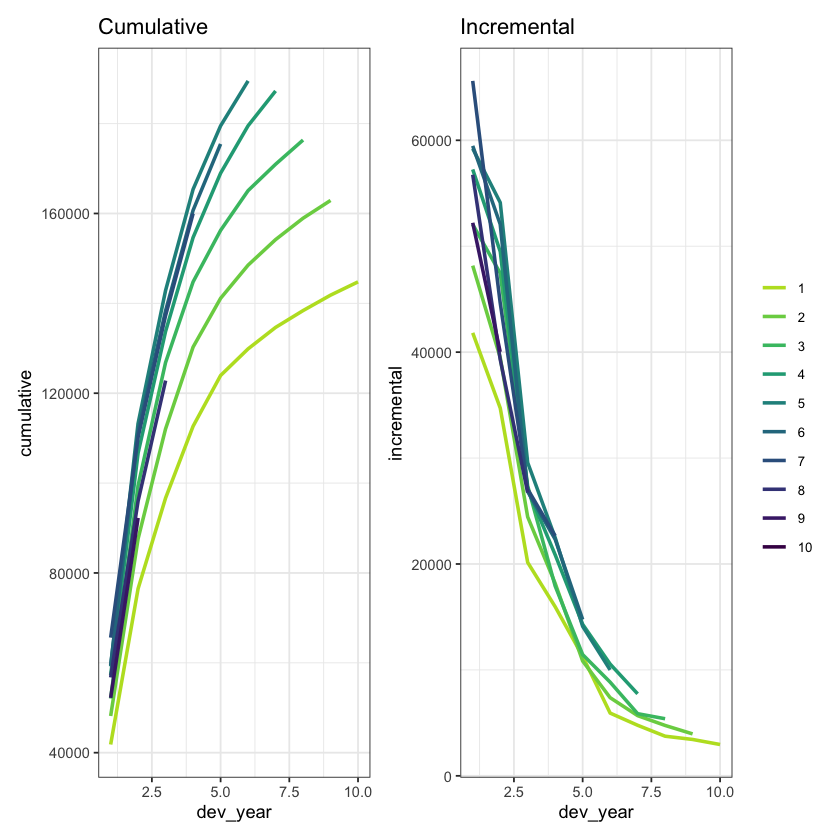

In [3]:

p1 <- ggplot(data=msdata, aes(x=dev_year, y=cumulative, colour=as.factor(acc_year))) +
	geom_line(size=1) +
	scale_color_viridis_d(begin=0.9, end=0) + 
	ggtitle("Cumulative") + 
	theme_bw() + 
	theme(legend.position = "none", legend.title=element_blank(), legend.text=element_text(size=8))


p2 <- ggplot(data=msdata, aes(x=dev_year, y=incremental, colour=as.factor(acc_year))) +
	geom_line(size=1) +
	scale_color_viridis_d(begin=0.9, end=0) + 
	ggtitle("Incremental") + 
	theme_bw() + 
	theme(legend.position = "right", legend.title=element_blank(), legend.text=element_text(size=8))

p1 + p2   # combine the plots using patchwork


The data look quite well behaved - each year seems to have a similar development pattern.

## Chain ladder model

### Fitting the model

Our first model will be the familiar chain ladder (volume all) model.
The monograph (and references therein) note that certain types of GLM gives exactly the same result as the chain ladder so I'm going to use that to get the chain ladder result. 

The specific model I'm using that replicates the chain ladder result is the Over-dispersed Poisson (ODP) cross classified (cc) model (Sections 3.3.2 and 3.3.3 of the monograph).

To apply the model, we will use the `glm` function from the base R **stats** package. The cross-classified model requires separate levels for each of accident and development year so we first make a factor version of these variates. I'm also going to add a calendar year term (`cal_year`) for later use in model diagnostics.

I use **data.table** for data manipulation. 
For those not familiar with it, `:=` is an assignment operator and the syntax `dt[, a := b]` creates a new variable called `a` in the `dt` data.table (which is also a data.frame), and sets it equal to `b`. 
The comma at the start is there because the first part of a data.table command subsets the data and is left blank if there is no subsetting required.


In [4]:

msdata[, acc_year_factor := as.factor(acc_year)
	   ][, dev_year_factor := as.factor(dev_year)
	     ][, cal_year := acc_year + dev_year - 1]

head(msdata)


acc_year,dev_year,cumulative,incremental,acc_year_factor,dev_year_factor,cal_year
<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
1,1,41821,41821,1,1,1
1,2,76550,34729,1,2,2
1,3,96697,20147,1,3,3
1,4,112662,15965,1,4,4
1,5,123947,11285,1,5,5
1,6,129871,5924,1,6,6


Now we fit the model and look at the results via `summary`.

* The family is the *quasipoisson* - this is how we fit an ODP model with `glm()`.
* The link is log
* The formula is simply `incremental ~ 0 + acc_year_factor + dev_year_factor`
    + The 0 tells `glm()` to fit a model without an intercept - which is how we fit the model in the monograph


In [5]:

glm_fit1 <- glm(data = msdata, 
	family = quasipoisson(link = "log"),
	formula = "incremental ~ 0 + acc_year_factor + dev_year_factor")


summary(glm_fit1)



Call:
glm(formula = "incremental ~ 0 + acc_year_factor + dev_year_factor", 
    family = quasipoisson(link = "log"), data = msdata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-21.493   -5.534    0.000    5.136   21.059  

Coefficients:
                  Estimate Std. Error t value             Pr(>|t|)    
acc_year_factor1  10.65676    0.03164 336.794 < 0.0000000000000002 ***
acc_year_factor2  10.79533    0.02994 360.507 < 0.0000000000000002 ***
acc_year_factor3  10.89919    0.02887 377.465 < 0.0000000000000002 ***
acc_year_factor4  10.98904    0.02808 391.326 < 0.0000000000000002 ***
acc_year_factor5  11.03883    0.02783 396.654 < 0.0000000000000002 ***
acc_year_factor6  11.01590    0.02855 385.867 < 0.0000000000000002 ***
acc_year_factor7  11.00808    0.02945 373.734 < 0.0000000000000002 ***
acc_year_factor8  10.89050    0.03266 333.463 < 0.0000000000000002 ***
acc_year_factor9  10.83613    0.03669 295.348 < 0.0000000000000002 ***
acc_year_factor10 10.69108  

I'm now going to save a more `data.table` version of the coefficient table in the `glm_fit1` object - this will be used later and having the coefficients available in a data.table makes things easier. I'll call this `coeff_table`.


In [6]:

# save the data for later use as a data.table
# variable 1 = parameter name
# variable 2 = parameter estimates
glm_fit1$coeff_table <- data.table(parameter = names(glm_fit1$coefficients), 
								   coeff_glm_fit1 = glm_fit1$coefficients)


head(glm_fit1$coeff_table)


parameter,coeff_glm_fit1
<chr>,<dbl>
acc_year_factor1,10.65676
acc_year_factor2,10.79533
acc_year_factor3,10.89919
acc_year_factor4,10.98904
acc_year_factor5,11.03883
acc_year_factor6,11.01590


### Loss reserve

Now we'll have a look at the loss reserve. If you've done the chain ladder calculations, you should find this gives the same answer.


In [7]:

# first make the lower triangle data set
ay <- NULL
dy <- NULL


for(i in 2:10){
	ay <- c(ay, rep(i, times=(i-1)))
	dy <- c(dy, (10-i+2):10)
}


futdata <- data.table(acc_year = ay, dev_year = dy)

# make factors
futdata[, cal_year := acc_year + dev_year
		][, acc_year_factor := as.factor(acc_year)
		  ][, dev_year_factor := as.factor(dev_year)]

# make the prediction and sum by acc_year
x <- predict(glm_fit1, newdata = futdata, type="response")
futdata[, incremental := x]


# data.table syntax to get summary by accident year
ocl_year <- futdata[,  lapply(.SD, sum), .SDcols=c("incremental"), by="acc_year"]

# total ocl
ocl_total <- futdata[, sum(incremental)]

# print the acc year table with total
ocl_year[, acc_year := as.character(acc_year) ]  # to make a table with total row
ocl_year_print <- rbind(ocl_year, data.table(acc_year="Total", incremental=ocl_total))
setnames(ocl_year_print, "incremental", "OCL")  # rename column for printing

ocl_year_print %>% 
  knitr::kable(digits=c(0, 0)) %>%
  as.character() %>%
  display_html()



acc_year,OCL
2,3398
3,8155
4,14579
5,22645
6,31865
7,45753
8,60093
9,80983
10,105874
Total,373346


### Model diagnostics

#### Calculations

So far, we've fitted a model and have calculated the loss reserve.
We can do all this with the chain ladder algorithm.
Now we start looking at some of the extras that using a GLM gives us - for a start the statistical model structure means that we can calculate residuals with known properties, assuming the assumptions underlying the model are valid. 

If the model assumptions are satisfied by the data, then the residuals should not have any remaining structure. 
Plots of residuals can therefore be useful to detect violations of model assumptions.
Note that we need to be careful to use the right types of residuals - in many cases we want to use standardised deviance residuals:

* Deviance residuals because the more recognisable Pearson residuals (based on actual - fitted) are difficult to interpret for non-normal models.
* Standardised because the raw residuals are on different scales depending on the scale of the underlying values.

Some more details may be found in Chapter 6 of the monograph and also in Chapter 5 of [A Practitioner's Introduction to Stochastic Reserving](http://mages.github.io/PSRWP/IFoA_PSRWP-PDF.pdf).

Here we look at the following:

* Residual Scatterplots
   + by linear predictor
   + by accident, development and calendar years
   + if the model assumptions are satisfied then the residuals should look homogeneous (or in layperson's language, like a random cloud), centred around zero)
   
* Heat map of actual vs fitted laid out in triangular form
   + In this we get the actual/fitted ratio in each (acc, dev) cell (subject to lower and upper bounds of [0.5, 2]) and then plot the colour-coded triangle of the actual/fitted values
   + heat maps are helpful to check for model fit and may help to identify missing interactions.

We have to prepare the data by adding the fitted values and residuals. 

* Because this model has a lot of parameters, there are two observations where the fitted is exactly equal to the actual -- (acc_year=1, dev_year=10) and (acc_year=10, dev_year=1). This is because these observations have a unique parameter.

* The deviance calculations below return `NaN` (not a number) for these points, but the residual should really be 0 so this adjustment is made manually. 

* Also add actual/fitted ratios and the log of these (restricted to the range [log(0.5), log(2)]) - these will be used for a heatmap later. 
  + The restricted range is used to generate easier to read shadings in the heat-map, while the conversion to log means that the shading scales will be similar intensity for $x$% and $1/x$ % 


*Technical note on residuals with `glm()`*

* The residuals in a glm object accessed with `$residuals` are residuals used in the model fitting algorithm.
* For diagnostic purposes, we require the standardised deviance residuals.
  + These are the signed square roots of the contribution of the i*th* observation to the deviance, divided by hat matrix values.
  + The `stats::rstandard()` function may be used with glm objects to extract the standardised deviance residuals.

<br>


In [8]:
msdata[, residuals1 := rstandard(glm_fit1)
	   ][, fitted1 := glm_fit1$fitted.values
	     ][, linear_predictor1 := log(fitted1)
	       ][, AvsF1 := incremental / fitted1
	         ][, AvsF_restricted1 := log(pmax(0.5, pmin(2,AvsF1)))]

# check for NaN residuals
msdata[is.nan(residuals1),]

# these occur where we expect them so so replace with 0
# the is.nan(residuals1) in an example of data.table subsetting - we only set the NaN resids to 0
msdata[is.nan(residuals1), residuals1 := 0]



acc_year,dev_year,cumulative,incremental,acc_year_factor,dev_year_factor,cal_year,residuals1,fitted1,linear_predictor1,AvsF1,AvsF_restricted1
<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,144781,2958,1,10,10,NaN,2958,7.992269,1,-0.0000000000000019984014
10,1,43962,43962,10,1,10,NaN,43962,10.691081,1,0.0000000000000008881784


Look at first 10 rows

In [9]:
head(msdata, 10)  # look at first 10 rows


acc_year,dev_year,cumulative,incremental,acc_year_factor,dev_year_factor,cal_year,residuals1,fitted1,linear_predictor1,AvsF1,AvsF_restricted1
<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,41821,41821,1,1,1,-0.37704981,42478.725,10.656759,0.9845164,-0.015604749951508145936
1,2,76550,34729,1,2,2,0.06821815,34616.808,10.452095,1.0032410,0.003235741327323749146
1,3,96697,20147,1,3,3,0.02211088,20117.514,9.909346,1.0014657,0.001464610789021573859
1,4,112662,15965,1,4,4,0.50192703,15368.757,9.640092,1.0387958,0.038062125103388820546
1,5,123947,11285,1,5,5,1.36344235,9948.355,9.205163,1.1343584,0.126067171138098593763
1,6,129871,5924,1,6,6,-1.13119533,6796.876,8.824218,0.8715769,-0.137451186377785167236
1,7,134646,4775,1,7,7,-0.33754581,4996.553,8.516503,0.9556589,-0.045354245283910396558
1,8,138388,3742,1,8,8,-0.56680264,4058.159,8.308485,0.9220929,-0.081109303248732236846
1,9,141823,3435,1,9,9,-0.01379476,3441.253,8.143591,0.9981829,-0.001818723883641001036


#### Plotting

Now let's look at the residual scatterplots.
In the linear predictor scatterplot, the points are colour coded so that the lighter points belong to the earlier development years, and the darker points belong to the later ones.


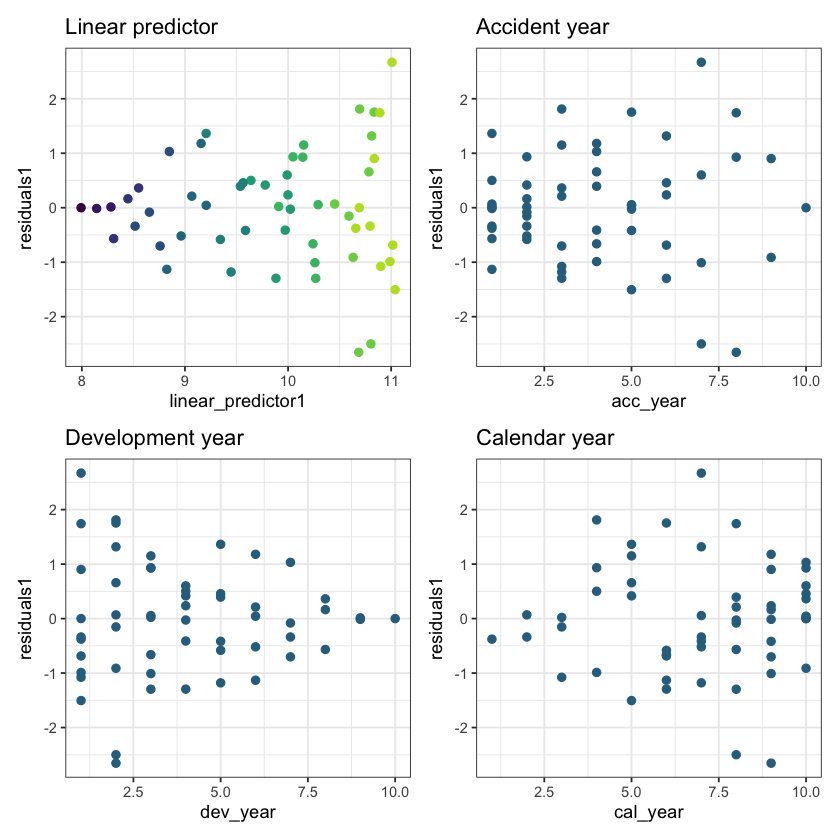

In [10]:

p1 <- ggplot(data=msdata, aes(x=linear_predictor1, y=residuals1, colour=dev_year)) +
	geom_point(size=2) +
	scale_colour_viridis(begin=0.9, end=0) +
	theme_bw() + 
	theme(legend.position = "none") +
	ggtitle("Linear predictor")


p2 <- ggplot(data=msdata, aes(x=acc_year, y=residuals1)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Accident year")

p3 <- ggplot(data=msdata, aes(x=dev_year, y=residuals1)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Development year")

p4 <- ggplot(data=msdata, aes(x=cal_year, y=residuals1)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Calendar year")

#p <- plot_grid(p1, p2, p3, p4, nrow=2, rel_widths = c(1,1,1,1))

(p1 + p2) / (p3 + p4)


These results are quite good - bear in mind there are only a small number of points so plots must be interpreted in relation to this. 
In particular:

* The residuals do not appear to fan out or fan in (once you take into account that later development years have small number of points)
* They appear centred around 0

Now construct and draw the heat map. Note that the colours are:

* blue (A/F = 50%)
* white (A/F = 100%)
* red (A/F = 200%)

with shading for in-between values


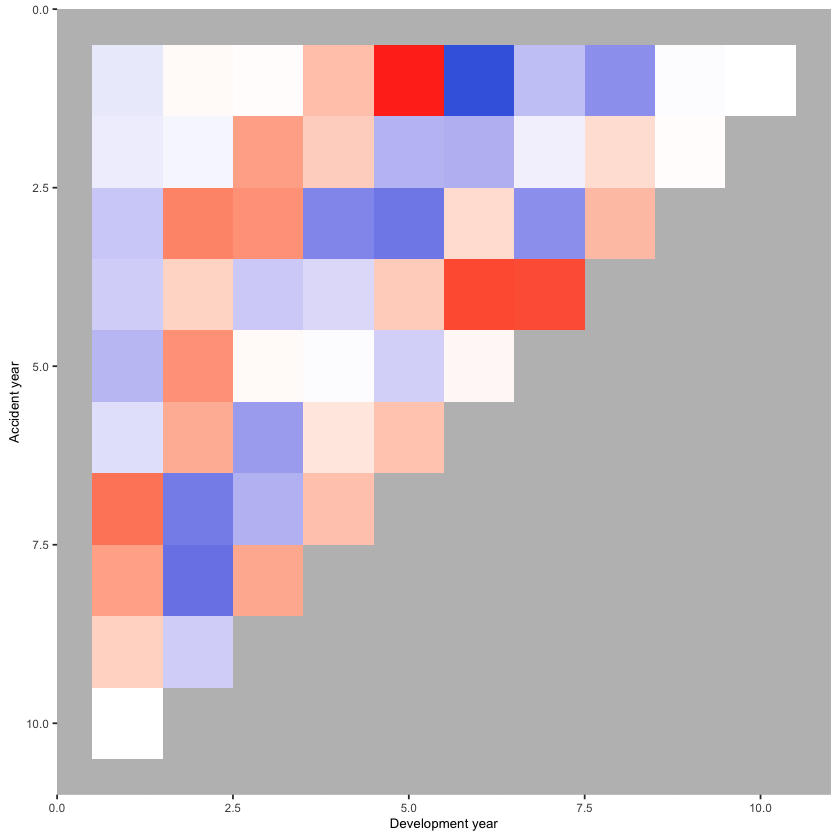

In [11]:

# heatmap code
# to get the correct shading I've plotted the log of the restricted A/F values

p_hm <- ggplot(data=msdata, aes(x=dev_year, y=acc_year)) + 
	geom_tile(aes(fill = AvsF_restricted1))+scale_y_reverse()+
	scale_fill_gradient2(name="AvF_min", low="royalblue", mid="white", high="red", midpoint=0, space="Lab", na.value="grey50", guide="colourbar")+
	labs(x="Development year", y="Accident year")+
	theme(legend.position = "none")+
	theme(axis.title.x = element_text(size=8), axis.text.x  = element_text(size=7))+
	theme(axis.title.y = element_text(size=8), axis.text.y  = element_text(size=7))+
	theme(panel.background = element_rect(fill = "grey", colour = "grey", size = 2, linetype = "solid"),
		  panel.grid = element_line(colour="grey")) + 
	NULL

print(p_hm)



In a heat map for a reserving triangle, we look for a random scattering of red and blue points. 
This plot looks quite good (though we'll revisit this shortly).


## Refining the model

We could stop here - and just use the results from this model, which match those produced by the chain ladder. 
The diagnostics suggest that the model fits quite well.
However, because this is a GLM, we have more options than just replicating the chain ladder.

In particular, can we:

* identify simplifications to the model to make it more parsimonious (i.e. reduce the number of parameters)?
* identify any areas of poorer fit that may suggest missing model terms including interactions?

### Simplifying the model

First we consider if we can use a parametric shape for the accident and development year parameters.
The end result should be something similar to the chain ladder approach but with far fewer parameters.

#### Accident year

First plot the accident year parameters.


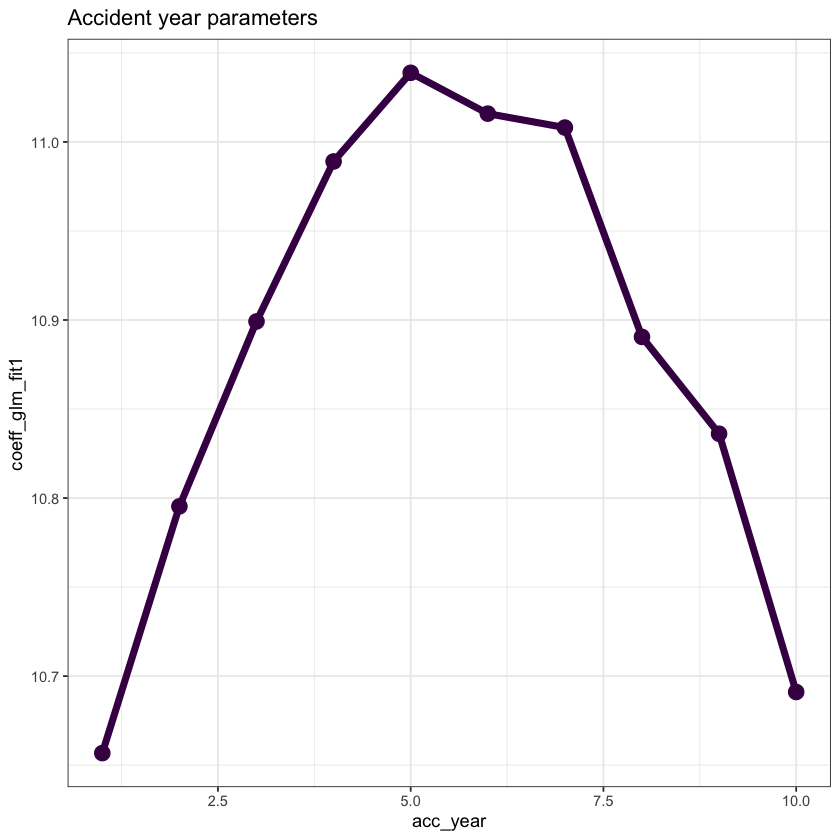

In [12]:

# extract the data
dt_acc_year <- glm_fit1$coeff_table[grepl("acc_year", parameter),  
									][, acc_year := as.integer(gsub("acc_year_factor", "", parameter))]


# plot
ggplot(data=dt_acc_year, aes(x=acc_year, y=coeff_glm_fit1)) +
	geom_line(size=2, colour="#440154ff") +
	geom_point(size=4, colour="#440154ff") + 
	theme_bw() + 
	ggtitle("Accident year parameters")



* Note that their shape closely resembles that of a parabola.
* This suggests that we can replace the 10 accident year parameters by
    + the overall intercept
    + an `acc_year` term
    + an `acc_year` squared term

* So refit the model on this basis.
    + Drop the 0 from the glm_fit1 formula to allow the model to have an intercept
    + Replace the acc_year_factor term with the parabola terms.


In [13]:

# add an x^2 term (we already have the x - acc_year)
msdata[, acc_year_2 := acc_year^2]

glm_fit2 <- glm(data = msdata, 
	family = quasipoisson(link = "log"),
	formula = "incremental ~ acc_year + acc_year_2 + dev_year_factor")


summary(glm_fit2)




Call:
glm(formula = "incremental ~ acc_year + acc_year_2 + dev_year_factor", 
    family = quasipoisson(link = "log"), data = msdata)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-28.5517   -5.1747    0.2691    4.5827   24.5421  

Coefficients:
                   Estimate Std. Error t value             Pr(>|t|)    
(Intercept)       10.470978   0.034414 304.264 < 0.0000000000000002 ***
acc_year           0.200075   0.014219  14.071 < 0.0000000000000002 ***
acc_year_2        -0.017907   0.001356 -13.210 < 0.0000000000000002 ***
dev_year_factor2  -0.205555   0.021276  -9.661     0.00000000000243 ***
dev_year_factor3  -0.750108   0.026492 -28.314 < 0.0000000000000002 ***
dev_year_factor4  -1.014806   0.030982 -32.755 < 0.0000000000000002 ***
dev_year_factor5  -1.451958   0.039797 -36.484 < 0.0000000000000002 ***
dev_year_factor6  -1.830488   0.051662 -35.432 < 0.0000000000000002 ***
dev_year_factor7  -2.142154   0.067504 -31.734 < 0.0000000000000002 ***
dev_ye

We see in the coefficient table part of the summary that the two acc_year terms are highly significant.

<br>

Now extract the coefficients and compare the previous and current fits.

* Remember that the intercept must be included in these calculations.
* Again, save the coefficient table as a data.table in the glm_fit2 object for later use.


In [14]:
# extract the coefficient table
glm_fit2$coeff_table <- data.table(parameter = names(glm_fit2$coefficients), 
                                   coeff_glm_fit2 = glm_fit2$coefficients)

#print(glm_fit2$coeff_table)  # easy print

# printing the table in a nicer format
glm_fit2$coeff_table %>% 
  kableExtra::kable(format = "html", escape = F) %>%    
  kableExtra::kable_styling(bootstrap_options = c("hover", "striped", "responsive"), 
                            full_width = FALSE, 
                            fixed_thead = TRUE) %>% 
  identity() %>%
  as.character() %>%
  display_html()



parameter,coeff_glm_fit2
(Intercept),10.4709782
acc_year,0.2000750
acc_year_2,-0.0179069
dev_year_factor2,-0.2055551
dev_year_factor3,-0.7501082
dev_year_factor4,-1.0148062
dev_year_factor5,-1.4519575
dev_year_factor6,-1.8304877
dev_year_factor7,-2.1421539
dev_year_factor8,-2.3526736


Now compare the past and current parameter estimates for accident year.

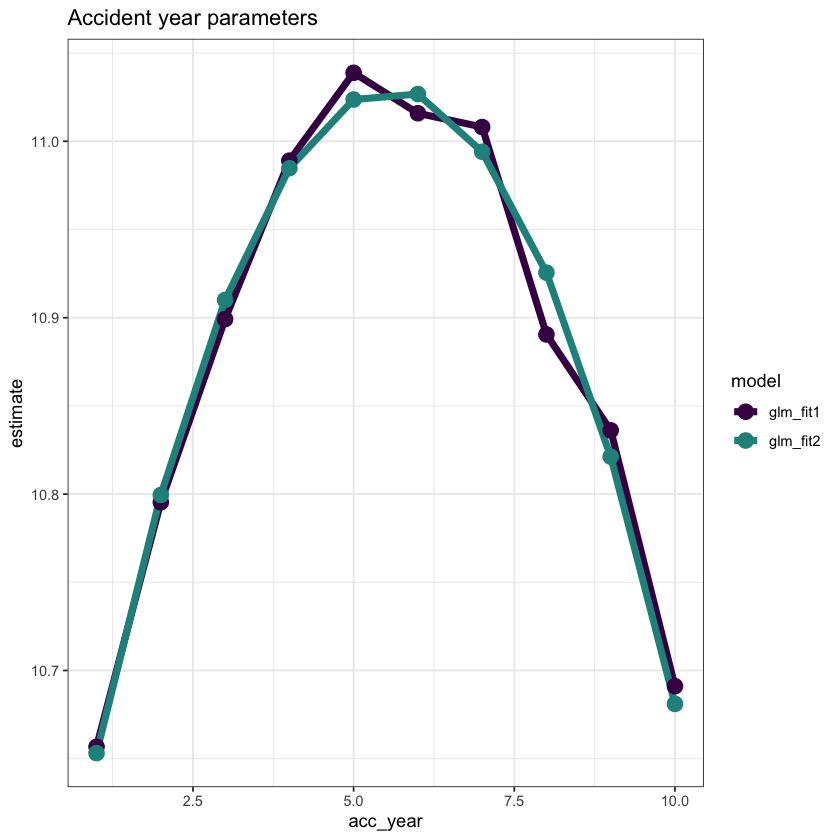

In [15]:

# pull out the acc year coefficinents only
dt_acc_year[, coeff_glm_fit2 := glm_fit2$coeff_table[parameter == "acc_year", coeff_glm_fit2]*acc_year + 
				glm_fit2$coeff_table[parameter == "acc_year_2", coeff_glm_fit2]*acc_year^2 + 
				glm_fit2$coeff_table[parameter == "(Intercept)", coeff_glm_fit2]]

# make long for ggplot
dt_acc_year_plot <- melt(dt_acc_year, 
                         id.vars = "acc_year", 
                         measure.vars = c("coeff_glm_fit1", "coeff_glm_fit2"), 
                         variable.name="model", 
                         value = "estimate")

# remove the coeff_ from the model names
dt_acc_year_plot[, model := gsub("coeff_", "", model, fixed=TRUE)]

ggplot(data=dt_acc_year_plot, aes(x=acc_year, y=estimate, colour=model)) +
	geom_line(size=2) +
	geom_point(size=4) +
	scale_colour_viridis_d(begin=0, end=0.5) + 
	theme_bw() + 
	ggtitle("Accident year parameters")




This looks very good - the fit is very similar, but we have 7 fewer parameters.

#### Development year

* Now we do the same thing for development year
* Note that the glm_fit2 model (and the glm_fit1 model too) do not have a parameter for dev_year = 1 as this is the base level.
    + This means that the parameter is really 0, so we must remember to include this.


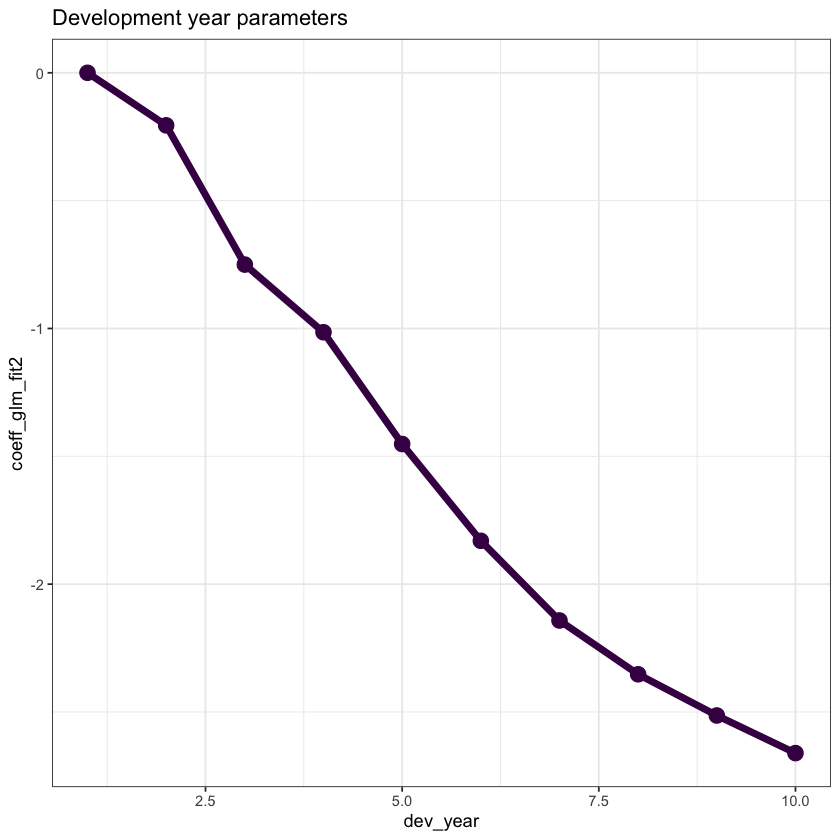

In [16]:

# extract the data
dt_dev_year <- glm_fit2$coeff_table[grepl("dev_year", parameter),  
									][, dev_year := as.integer(gsub("dev_year_factor", "", parameter))][]   # known data.table printing bug

# add year 1
dt_dev_year <- rbind(dt_dev_year, data.table(parameter="dev_year_factor1", coeff_glm_fit2=0, dev_year=1))
setorder(dt_dev_year, dev_year)


# plot
ggplot(data=dt_dev_year, aes(x=dev_year, y=coeff_glm_fit2)) +
	geom_line(size=2, colour="#440154ff") +
	geom_point(size=4, colour="#440154ff") +
	theme_bw() +
	ggtitle("Development year parameters")



* Looking at this plot, it appears that a straight line would fit quite well
* This fit would be improved by allowing the straight line to bend (have a knot) at dev_year = 7
    + So let's try this below
    + note we actually fit dev_year - 1 rather than dev_year
        - this means that the parameter estimate at dev_year = 1 is 0, just as it is in the glm_fit2 model, so it makes the results comparable
        - if we fit dev_year, then the parameter estimate at dev_year=1 would be non-zero, so the two fits would be shifted relative to each other and we would need to adjust for that.


In [17]:

# add dev-1 and dev-7 terms
msdata[, dev_year_m1 := dev_year - 1]
msdata[, dev_year_ge_7 := pmax(dev_year-7.5, 0)]

# fit the model
glm_fit3 <- glm(data = msdata, 
	family = quasipoisson(link = "log"),
	formula = "incremental ~ acc_year + acc_year_2 + dev_year_m1 + dev_year_ge_7")

# extract and save the coefficient table
glm_fit3$coeff_table <- data.table(parameter = names(glm_fit3$coefficients), 
                                   coeff_glm_fit3 = glm_fit3$coefficients)

# display a summary of the model
summary(glm_fit3)




Call:
glm(formula = "incremental ~ acc_year + acc_year_2 + dev_year_m1 + dev_year_ge_7", 
    family = quasipoisson(link = "log"), data = msdata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-25.301   -9.262   -2.080    5.893   42.841  

Coefficients:
               Estimate Std. Error t value             Pr(>|t|)    
(Intercept)   10.509475   0.052096 201.734 < 0.0000000000000002 ***
acc_year       0.204224   0.021608   9.451     0.00000000000104 ***
acc_year_2    -0.018295   0.002058  -8.891     0.00000000000719 ***
dev_year_m1   -0.364073   0.008845 -41.160 < 0.0000000000000002 ***
dev_year_ge_7  0.238860   0.088426   2.701              0.00941 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 242.0614)

    Null deviance: 750824  on 54  degrees of freedom
Residual deviance:  11879  on 50  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


* Assuming the fit is satisfactory, our original model with 19 parameters has now been simplified to 5 parameters - much more parsimonious and robust.
* Let's check the fit by dev_year to see.


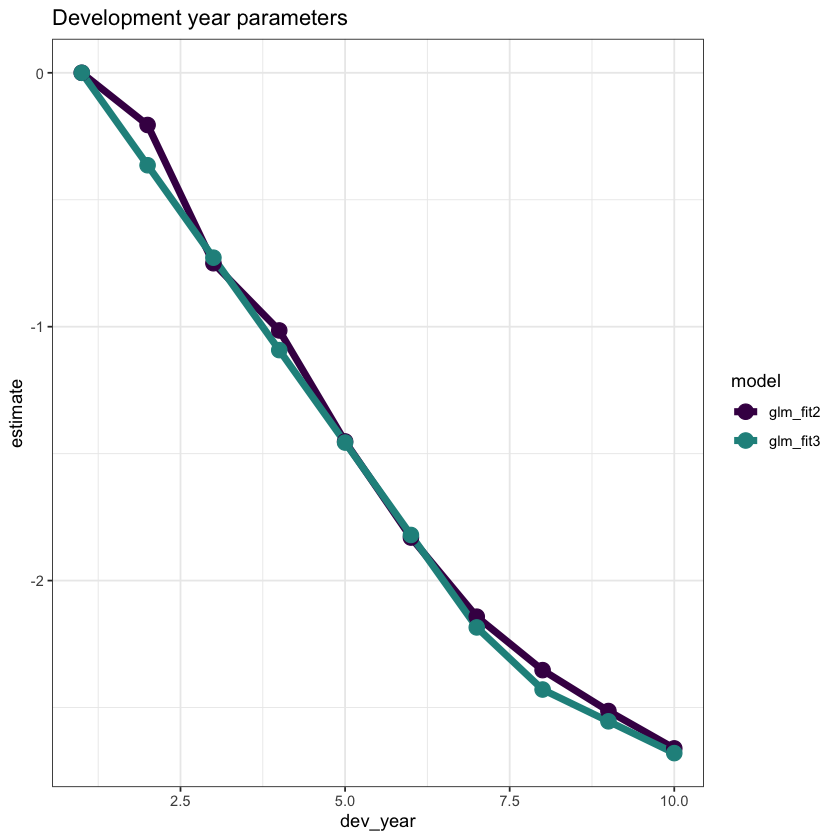

In [18]:

# get the dev_year fit under the new model and add to the data.table containing the factor level parameters
p1 <- glm_fit3$coeff_table[parameter == "dev_year_m1", coeff_glm_fit3]
p2 <- glm_fit3$coeff_table[parameter == "dev_year_ge_7", coeff_glm_fit3]
dt_dev_year[, coeff_glm_fit3 := p1*(dev_year-1) + p2*pmax(0, dev_year-7.5) ]


# make long for ggplot
dt_dev_year_plot <- melt(dt_dev_year, id.vars = "dev_year", measure.vars = c("coeff_glm_fit2", "coeff_glm_fit3"), variable.name="model", value = "estimate")

# remove the coeff_ from the model names
dt_dev_year_plot[, model := gsub("coeff_", "", model, fixed=TRUE)]


ggplot(data=dt_dev_year_plot, aes(x=dev_year, y=estimate, colour=model)) +
	geom_line(size=2) +
	geom_point(size=4) +
	scale_colour_viridis_d(begin=0, end=0.5) +
	theme_bw() +
	ggtitle("Development year parameters")




* This looks good.
* However dev_year = 2 is a bit underfit in the latest model, so we can add something to improve this fit (a term at dev_year=2)
* So refit and replot.


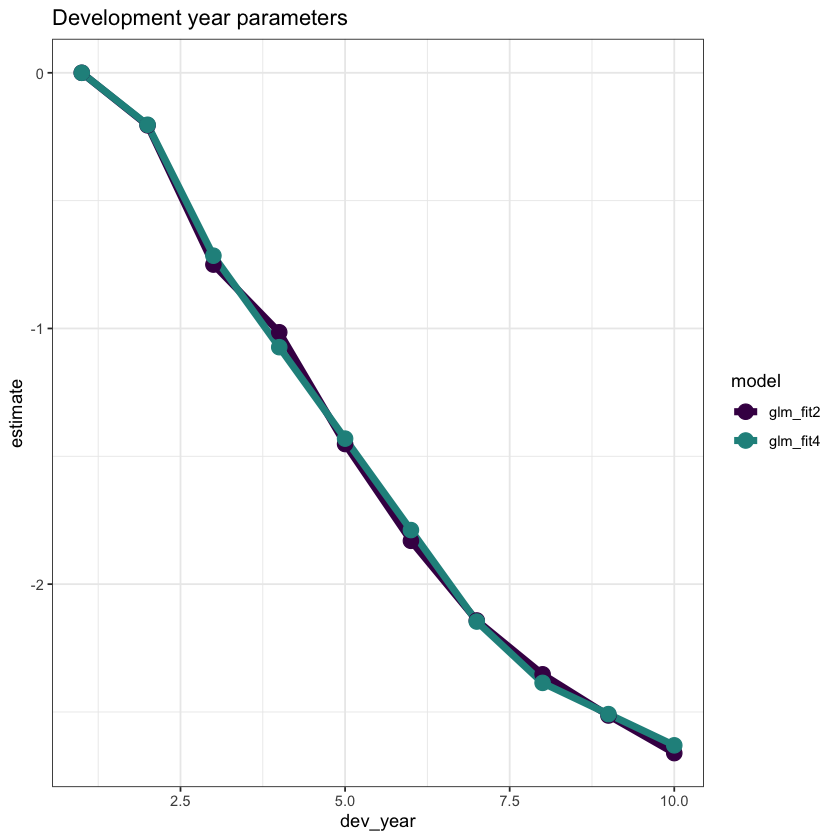

In [19]:

msdata[, dev_year_eq_2 := as.integer(dev_year == 2)]

glm_fit4 <- glm(data = msdata, 
	family = quasipoisson(link = "log"),
	formula = "incremental ~ acc_year + acc_year_2 + dev_year_m1 + dev_year_ge_7 + dev_year_eq_2")


glm_fit4$coeff_table <- data.table(parameter = names(glm_fit4$coefficients), coeff_glm_fit4 = glm_fit4$coefficients)


p1 <- glm_fit4$coeff_table[parameter == "dev_year_m1", coeff_glm_fit4]
p2 <- glm_fit4$coeff_table[parameter == "dev_year_ge_7", coeff_glm_fit4]
p3 <- glm_fit4$coeff_table[parameter == "dev_year_eq_2", coeff_glm_fit4]
dt_dev_year[, coeff_glm_fit4 := p1*(dev_year-1) + p2*pmax(0, dev_year-7.5) + p3*(dev_year == 2) ]


# make long for ggplot
dt_dev_year_plot <- melt(dt_dev_year, id.vars = "dev_year", measure.vars = c("coeff_glm_fit2", "coeff_glm_fit4"), variable.name="model", value = "estimate")

# remove the coeff_ from the model names
dt_dev_year_plot[, model := gsub("coeff_", "", model, fixed=TRUE)]


ggplot(data=dt_dev_year_plot, aes(x=dev_year, y=estimate, colour=model)) +
	geom_line(size=2) +
	geom_point(size=4) +
	scale_colour_viridis_d(begin=0, end=0.5) +
	theme_bw() +
	ggtitle("Development year parameters")




Looks good! Fitting `dev_year`=2 better has also improved the tail fitting (`dev_year`>7).

### Identifying missing structure

* The second part of the model refining process involves checking for missing structure.
* Let's have a better look at the heat map, as it stands after the model simplification process


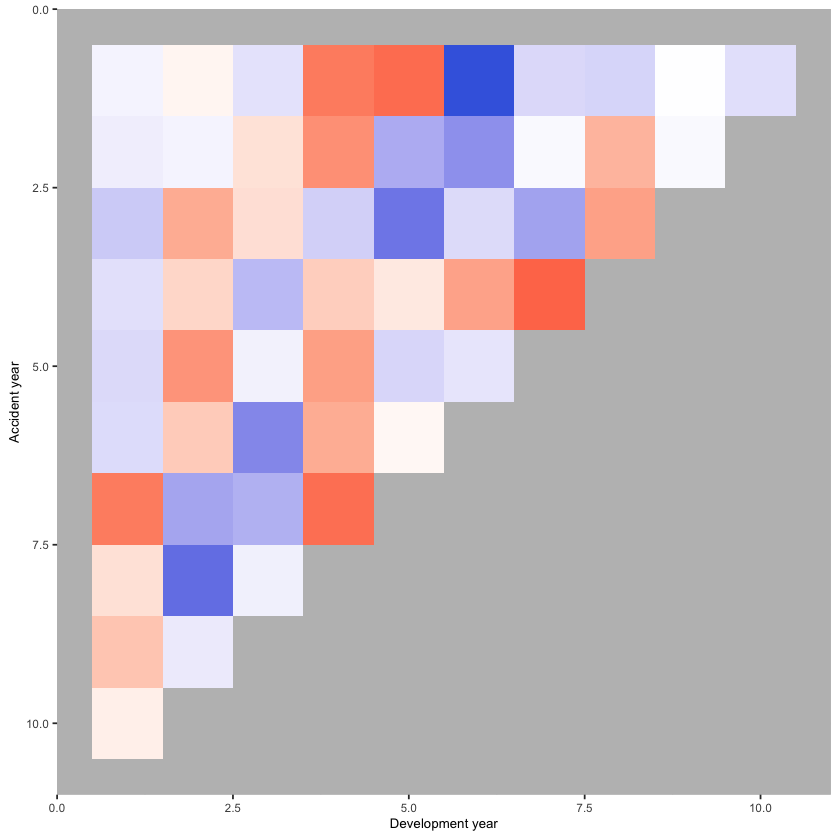

In [20]:
msdata[, residuals4 := rstandard(glm_fit4)
	   ][, fitted4 := glm_fit4$fitted.values
	     ][, linear_predictor4 := log(fitted4)
	       ][, AvsF4 := incremental / fitted4
	         ][, AvsF_restricted4 := log(pmax(0.5, pmin(2,AvsF4)))]


p_hm <- ggplot(data=msdata, aes(x=dev_year, y=acc_year)) + 
	geom_tile(aes(fill = AvsF_restricted4))+scale_y_reverse()+
	scale_fill_gradient2(name="AvF_min", low="royalblue", mid="white", high="red", midpoint=0, space="Lab", na.value="grey50", guide="colourbar")+
	labs(x="Development year", y="Accident year")+
	theme(legend.position = "none")+
	theme(axis.title.x = element_text(size=8), axis.text.x  = element_text(size=7))+
	theme(axis.title.y = element_text(size=8), axis.text.y  = element_text(size=7))+
	theme(panel.background = element_rect(fill = "grey", colour = "grey", size = 2, linetype = "solid"),
		  panel.grid = element_line(colour="grey")) + 
	NULL

print(p_hm)



Let's add some annotations to highlight some structure


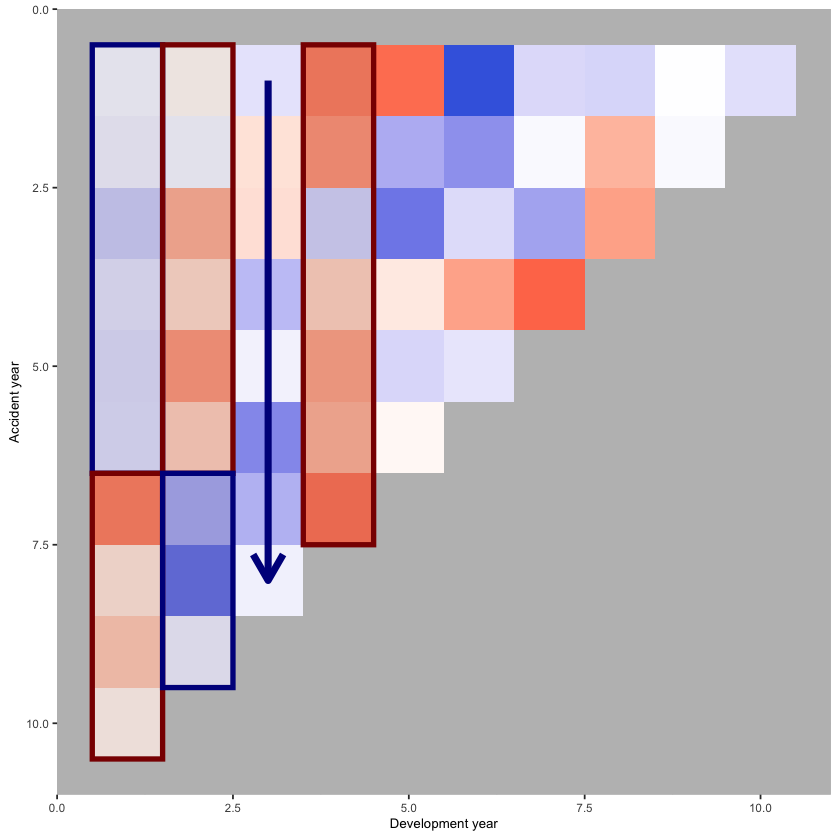

In [21]:

p_hm + 
	annotate(geom="rect", xmin= 0.5, xmax=1.5, ymin=0.5, ymax=6.5, colour="darkblue", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 0.5, xmax=1.5, ymin=6.5, ymax=10.5, colour="darkred", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 1.5, xmax=2.5, ymin=0.5, ymax=6.5, colour="darkred", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 1.5, xmax=2.5, ymin=6.5, ymax=9.5, colour="darkblue", alpha=0.1, size=1.5) +
	annotate(geom="segment", x=3, xend=3, y=1, yend=8, arrow=arrow(), colour="darkblue", size=2) +
	annotate(geom="rect", xmin= 3.5, xmax=4.5, ymin=0.5, ymax=7.5, colour="darkred", alpha=0.1, size=1.5) 




We see:

* development year 1, a distinct area of blue in the earlier accident years (A < F), followed by red (A > F)
* development year 2, a distinct area of red in the earlier accident years (A > F), followed by blue (A < F)
* development year 3, a possible progression from red to blue with increasing accident year (F increasing relative to A)
* development year 4, nearly all red (A > F)

This suggests the payment pattern has altered and can be accommodated by (mostly) interaction terms within the GLM. Consider adding the following terms:

* (development year = 1) * (accident year is between 1 and 6)
* (development year = 2) * (accident year is between 1 and 6)
* (development year = 3) * (accident year linear trend)
* (development year = 4) 

So, let's refit the model with terms to capture these and have a look at the heat map again


In [22]:

# add the new terms
msdata[, dev_year_eq_1 := as.integer(dev_year == 1)]
msdata[, dev_year_eq_3 := as.integer(dev_year == 3)]
msdata[, dev_year_eq_4 := as.integer(dev_year == 4)]
msdata[, acc_year_1_6 := as.integer(acc_year >= 1 & acc_year <= 6)]


glm_fit5 <- glm(data = msdata, 
	family = quasipoisson(link = "log"),
	formula = "incremental ~ acc_year + acc_year_2 + dev_year_m1 + dev_year_ge_7 + dev_year_eq_2 + dev_year_eq_4 +
	dev_year_eq_1:acc_year_1_6 +  dev_year_eq_2:acc_year_1_6 + dev_year_eq_3:acc_year ")


summary(glm_fit5)

# save for later use
glm_fit5$coeff_table <- data.table(parameter = names(glm_fit5$coefficients), coeff_glm_fit5 = glm_fit5$coefficients)




Call:
glm(formula = "incremental ~ acc_year + acc_year_2 + dev_year_m1 + dev_year_ge_7 + dev_year_eq_2 + dev_year_eq_4 +\n\tdev_year_eq_1:acc_year_1_6 +  dev_year_eq_2:acc_year_1_6 + dev_year_eq_3:acc_year ", 
    family = quasipoisson(link = "log"), data = msdata)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-13.7416   -3.8986   -0.4483    5.3380   13.4570  

Coefficients:
                            Estimate Std. Error t value             Pr(>|t|)
(Intercept)                10.490384   0.032004 327.787 < 0.0000000000000002
acc_year                    0.206624   0.010871  19.007 < 0.0000000000000002
acc_year_2                 -0.018333   0.001140 -16.078 < 0.0000000000000002
dev_year_m1                -0.368487   0.006911 -53.317 < 0.0000000000000002
dev_year_ge_7               0.271988   0.044265   6.145           0.00000019
dev_year_eq_2               0.037485   0.024691   1.518              0.13596
dev_year_eq_4               0.052800   0.023821   2.217

This model should match that displayed in Table 7-5 of the monograph - and indeed it does (some very minor differences in parameter values - the model in the monograph was fitted in SAS).

Look at the updated heat map again with the annotations - has the model resolved the identified issues?


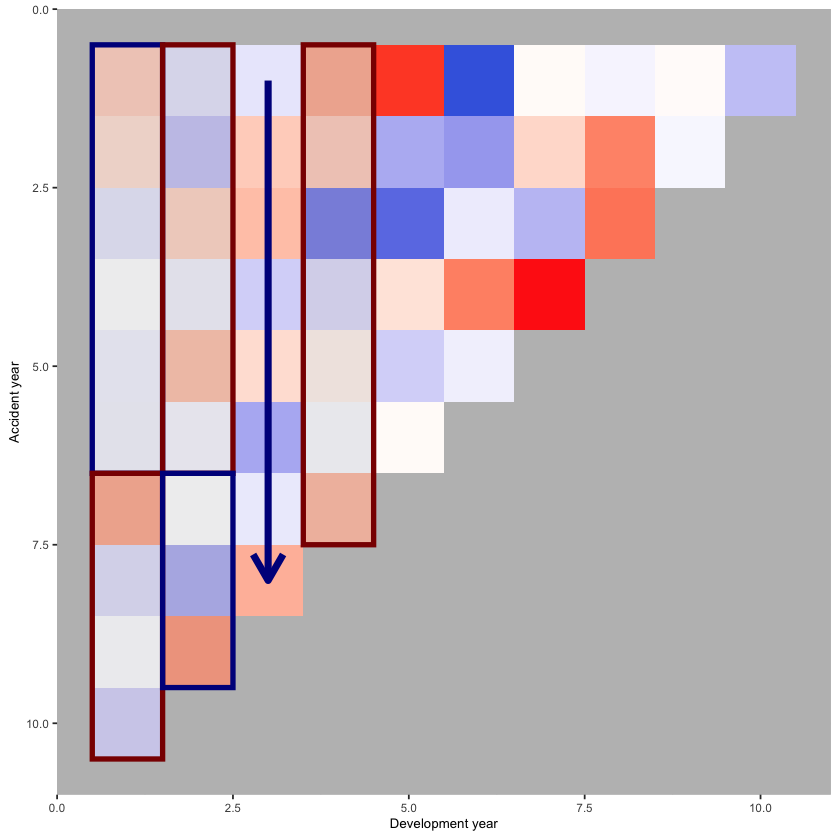

In [23]:
# attach fitteds and residuals
msdata[, residuals5 := rstandard(glm_fit5)
	   ][, fitted5 := glm_fit5$fitted.values
	     ][, linear_predictor5 := log(fitted5)
	       ][, AvsF5 := incremental / fitted5
	         ][, AvsF_restricted5 := log(pmax(0.5, pmin(2,AvsF5)))]



p_hm <- ggplot(data=msdata, aes(x=dev_year, y=acc_year)) + 
	geom_tile(aes(fill = AvsF_restricted5))+scale_y_reverse()+
	scale_fill_gradient2(name="AvF_min", low="royalblue", mid="white", high="red", midpoint=0, space="Lab", na.value="grey50", guide="colourbar")+
	labs(x="Development year", y="Accident year")+
	theme(legend.position = "none")+
	theme(axis.title.x = element_text(size=8), axis.text.x  = element_text(size=7))+
	theme(axis.title.y = element_text(size=8), axis.text.y  = element_text(size=7))+
	theme(panel.background = element_rect(fill = "grey", colour = "grey", size = 2, linetype = "solid"),
		  panel.grid = element_line(colour="grey")) + 
	annotate(geom="rect", xmin= 0.5, xmax=1.5, ymin=0.5, ymax=6.5, colour="darkblue", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 0.5, xmax=1.5, ymin=6.5, ymax=10.5, colour="darkred", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 1.5, xmax=2.5, ymin=0.5, ymax=6.5, colour="darkred", alpha=0.1, size=1.5) +
	annotate(geom="rect", xmin= 1.5, xmax=2.5, ymin=6.5, ymax=9.5, colour="darkblue", alpha=0.1, size=1.5) +
	annotate(geom="segment", x=3, xend=3, y=1, yend=8, arrow=arrow(), colour="darkblue", size=2) +
	annotate(geom="rect", xmin= 3.5, xmax=4.5, ymin=0.5, ymax=7.5, colour="darkred", alpha=0.1, size=1.5) 


print(p_hm)




This looks much better.

We should also look at the residual plots again


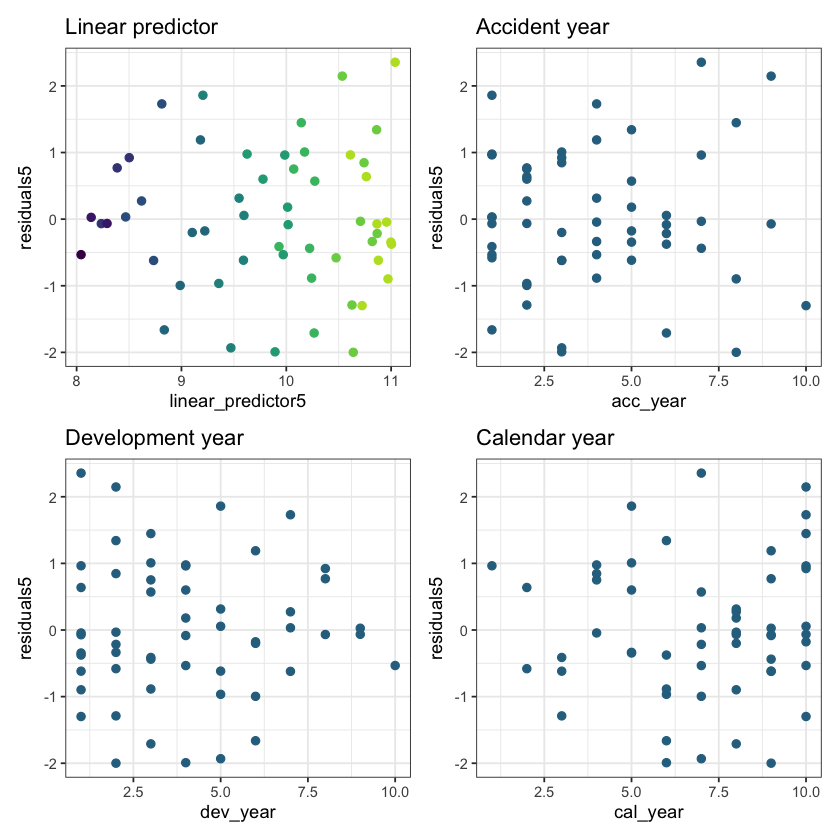

In [24]:

p1 <- ggplot(data=msdata, aes(x=linear_predictor5, y=residuals5, colour=dev_year)) +
	geom_point(size=2) +
	scale_colour_viridis(begin=0.9, end=0) +
	theme_bw() + 
	theme(legend.position = "none") +
	ggtitle("Linear predictor")


p2 <- ggplot(data=msdata, aes(x=acc_year, y=residuals5)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Accident year")

p3 <- ggplot(data=msdata, aes(x=dev_year, y=residuals5)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Development year")

p4 <- ggplot(data=msdata, aes(x=cal_year, y=residuals5)) +
	geom_point(size=2, colour="#2d708eff") +
	theme_bw() + 
	ggtitle("Calendar year")

(p1 + p2) / (p3 + p4)



These residuals do look better than those from the chain ladder model. 

### Loss reserve

Now that we have a model, let's produce the estimate of the outstanding claims by accident year and in total.

* Take the lower triangle data [futdata] created above
* Add on the new variates we created
* Score the model on this data
* Summarise the results

Create the data and score using `predict()`. Store the predicted values in the incremental column.


In [25]:

# add all model variates
futdata[, acc_year_2 := acc_year^2
		][, dev_year_m1 := dev_year - 1
		  ][, dev_year_ge_7 := pmax(0, dev_year - 7.5)
		    ][, dev_year_eq_1 := as.integer(dev_year == 1)
		      ][, dev_year_eq_2 := as.integer(dev_year == 2)
		        ][, dev_year_eq_3 := as.integer(dev_year == 3)
		          ][, dev_year_eq_4 := as.integer(dev_year == 4)
		            ][, acc_year_1_6 := as.integer(acc_year>=1 & acc_year <=6)]


x <- predict(glm_fit5, newdata = futdata, type="response")
futdata[, incremental := x]

head(futdata)



acc_year,dev_year,cal_year,acc_year_factor,dev_year_factor,incremental,acc_year_2,dev_year_m1,dev_year_ge_7,dev_year_eq_1,dev_year_eq_2,dev_year_eq_3,dev_year_eq_4,acc_year_1_6
<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
2,10,12,2,10,3618.769,4,9,2.5,0,0,0,0,1
3,9,12,3,9,4470.907,9,8,1.5,0,0,0,0,1
3,10,13,3,10,4059.635,9,9,2.5,0,0,0,0,1
4,8,12,4,8,5324.841,16,7,0.5,0,0,0,0,1
4,9,13,4,9,4835.016,16,8,1.5,0,0,0,0,1
4,10,14,4,10,4390.250,16,9,2.5,0,0,0,0,1


Get reserves by accident year and in total 

In [26]:

ocl_year <- futdata[,  lapply(.SD, sum), .SDcols=c("incremental"), by="acc_year"]
ocl_total <- ocl_year[, sum(incremental)]


ocl_year %>% 
  knitr::kable(digits=c(0, 0)) %>%
  as.character() %>%
  display_html()


acc_year,incremental
2,3619
3,8531
4,14550
5,22173
6,32458
7,45695
8,62955
9,79301
10,101212


The total reserve is `r ocl_total %>% round(0)`.


## Reviewing this example

Looking back over this example, what we have done is started with a chain ladder model and then shown how we can use a GLM to fit a more parsimonious model (i.e. fewer parameters).
It may then be possible to reconcile the shape of the parametric fit by accident year to underlying experience in the book - here we saw higher payments in the middle accident years. Is this due to higher claims experience or higher premium volumes? Does this give us an insight that allows us to better extrapolate into the future when setting reserves?

We have also used model diagnostics to identify areas of misfit and then used GLM interactions to capture these changes. 

<br>

## Practical use of GLMs in traditional reserving

### Modelling

The ideas in this simple example extend to more complex traditional scenarios. By traditional I mean that the data you have available to you are classified by accident (or underwriting), development and calendar periods only. 

First decide what you are going to model. Here we had a single model of incremental payments. However you could fit a *Payments Per Claim Finalised (PPCF)* model which consists of 3 submodels - numbers of claims incurred by accident period, number of claims finalised by (accident, development period) and payments per claim finalised by (accident, development period). Each of these could then be fitted by a GLM.

For whatever you're modelling, you then pick the two triangle directions that you think are most critical for that experience. 
You can't include all 3 at the start since they are correlated. 

So, for PPCF submodels:

* for number of claims incurred models, accident and development period effects are likely to be where you start.
* numbers of claims finalised will usually depend on development period (type of claim) and calendar period (to take account of changes in claim settlement processes)
* for claim size models, you will probably want development and calendar period effects. For these models you could use operational time instead of development period to avoid changes in the timing of claims finalisations impacting your model.

Then fit the models by starting with the modelled effects as factors and use methods such as those outlined above to reduce the number of parameters by using parametric shapes.
Look for missing structure and consider adding interactions or (carefully) adding limited functions of the third triangular direction.
Take advantage of GLM tools to refine your model. Use what you know about the portfolio to inform your model - if you know that there was a period of rapid claims inflation, then include that in your model.

### Setting reserves

It is possible to overlay judgement onto a GLM's predictions. 
At the end of the day, the predictions are just based on a mathematical formula.
So, taking claims inflation as an example, if you've been seeing 5% p.a. over the last 3 years, but you think this is going to moderate going forward, then you can adjust the projections by removing the 5% p.a. rate into the future and replacing it with, say, 2% p.a.
Once you get familiar with using GLMs, you might find it easier to incorporate judgement - the GLM can capture more granularity about past experience which in turn may make it easier to work out how things might change in future and how to numerically include these changes.

### Additional References

The references below have further examples of fitting GLMs in this way, and show how to capture quite complex experience.
Although both use individual data, the methodology can be used in a similar manner for aggregate data.

* [Loss Reserving with GLMs: A Case Study](https://www.casact.org/sites/default/files/2021-02/pubs_dpp_dpp04_04dpp327.pdf)
* [Individual Claim modelling of CTP data](https://actuaries.asn.au/Library/6.a_ACS07_paper_McGuire_Individual%20claim%20modellingof%20CTP%20data.pdf)
* [Predictive modeling applications in actuarial science, Frees and Derig, 2004](https://instruction.bus.wisc.edu/jfrees/jfreesbooks/PredictiveModelingVol1/index.htm) - in particular see Chapter 18 in Volume 1 and Chapter 3 in Volume 2.

Please feel free to add references to other useful material in the comments.

## Session information

To assist with reproducibility in future, here are details of my R session.


In [27]:
sessionInfo()  

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] IRdisplay_1.0     kableExtra_1.3.4  magrittr_2.0.1    patchwork_1.1.1  
[5] viridis_0.6.1     viridisLite_0.4.0 ggplot2_3.3.4     data.table_1.14.0
[9] here_1.0.1       

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.1  xfun_0.23         repr_1.1.3       
 [5] purrr_0.3.4       colorspace_2.0-1  vctrs_0.3.8       generics_0.1.0   
 [9] htmltools_0.5.1.1 base64enc_0.1-3   utf8_1.2.1        rlang_0.4.11     
[13] pillar_1.6.1      glue_1.4.2        withr